# Deep Learning Model Analysis

This notebook contains three sections which analyse the data and models trained in the *model_training.ipynb* notebook:

+ In section [1. Load data and model](#1ma) the data and trained model of the ePodium and the DDP dataset are loaded.
+ In section [2. Make predictions on test set](#2ma) the loaded model is used to make predictions on the test set. 
+ In section [3. Show results](#3ma) the loss of the test set is calculated and the predictions are plotted in a scatterplot.

#### Import Packages
Note: This notebook may output tensorflow errors if cuda is not properly installed. The notebook still functions with these errors.

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets
import tensorflow as tf
from IPython.display import clear_output

# Local
import local_paths
from functions import epodium, display_helper, processing
from functions.epodium import Epodium
from functions.ddp import DDP
from functions.sequences import EpodiumSequence, DDPSequence

# Models
from models.dl_4_tsc import encoder_model, fully_convolutional_model, resnet_model
from models.eeg_dl import transformer_model

2022-11-12 12:05:05.190999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 12:05:05.191040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



---
<br>

<a id="1ma"></a>
## 1. Load data and model

Choose the DDP or ePodium dataset to make predictions on:

#### Choose the dataset


In [2]:
def choose_dataset(dataset_name):
    global labels, dataset
    if dataset_name == "epodium":
        dataset = Epodium()
        labels = dataset.create_labels(local_paths.ePod_metadata)
    elif dataset_name == "ddp":
        dataset = DDP()
        directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
        labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)

    print(f"Using dataset: {dataset_name}.")

# Widget settings
dataset_name_w = ipywidgets.RadioButtons(description='Dataset:', options=["ddp", "epodium"], value="ddp")
ui = ipywidgets.HBox([dataset_name_w])
out = ipywidgets.interactive_output(choose_dataset, {'dataset_name': dataset_name_w})
display(ui, out)

Output()

### Load a trained model
Choose from the trained models in the _local_paths.models_ folder.

In [90]:
# Required plot setting:
%matplotlib inline 

# history = []
                                       
def load_model(trained_model):
    try:
        base_path = os.path.join(local_paths.models, trained_model)
    except:
        print("No models found.")
        return
    path_history = os.path.join(base_path, "history.npy")
    path_model = os.path.join(base_path, "model")
    path_testset = os.path.join(base_path, "subsets", "test_set.txt")
    path_weights = os.path.join(base_path, "weights.h5")
    
    global model
    global testset
    global history

    # Load Model
    if(os.path.exists(path_model)):
        print(f"\nLoading Model: '{model_name_w.value}'.")

        # Loads the entire model from a folder:
        model = tf.keras.models.load_model(path_model)
        model.load_weights(path_weights)
        # Reads the test-set of the trained model and puts the experiment names into a list:
        testset = open(path_testset, "r").read().split()
        # Loads the training history dictionary:
        history = np.load(path_history, allow_pickle=True).item()        

        # Show Loss of Training History
        print(f"\nThe lowest validation loss is: {round(min(history['val_loss']), 3)} at epoch {np.argmin(history['val_loss'])}\n")
        if "age" in trained_model:
            xlim, ylim = [0,100], [0,150000]
        if "dyslexia" in trained_model:
            xlim, ylim = [0,100], [0,0.1]
        display_helper.show_plot(x=range(len(history['loss'])), 
                                 y=[history['loss'], history['val_loss']], 
                                 legend=["loss","validation loss"], 
                                 xlabel="epochs", ylabel="validation loss (MSE)", 
                                 title=f"Loss during training ({trained_model})",
                                 xlim=xlim, ylim=ylim)
        
        # Load Model predictions
        predictions_file_name = "predictions_age_"+dataset_name_w.value+".txt"
        predictions_path = os.path.join(local_paths.models, model_name_w.value, predictions_file_name)

        if os.path.exists(predictions_path):
            global results
            results = np.loadtxt(predictions_path)
            print(f"Results loaded: {predictions_file_name} from {model_name_w.value}")    
        else:
            print(f"Could not load {predictions_file_name} from {model_name_w.value}, make predictions in the following code.")

    else: 
        print("The model is untrained.")
       
    

# Find all models in 'local_paths.models' 
all_trained_models = sorted(f for f in os.listdir(os.path.join(local_paths.models)) if not "." in f)
# models_dataset = [m for m in all_trained_models if dataset_name_w.value in m] 


# Widget for selecting the trained models
model_name_w = ipywidgets.RadioButtons(options=all_trained_models, description='Models:')
display(model_name_w)
out = ipywidgets.interactive_output(load_model, {'trained_model': model_name_w})
display(out)

RadioButtons(description='Models:', options=('ddp_encoder_age', 'ddp_encoder_age_Hz200', 'ddp_encoder_age_avg1…

Output()

<br>

<a id='2ma'></a>
### 2. Make predictions on test set

The predictions are made by predicting the label of multiple ERPs generated from the same experiment. Each ERP is different, since a random subset of the total number of epochs is used for creating the ERPs.

+ *n_passthroughs* is the number of predictions made from the same experiment. A higher number takes longer to process but is more accurate.

In [ ]:
n_passthroughs = 30

predictions_path = os.path.join(local_paths.models, model_name_w.value, "predictions_age_"+dataset_name_w.value+".txt")
if os.path.exists(predictions_path):
    print(f"The predictions of model '{model_name_w.value}' to dataset '{dataset_name_w.value}' are already saved.")
else:
    results = []

    # Transfer learning, get entire ePodium dataset as testset:
    if dataset_name_w.value  == "epodium" and "ddp" in model_name_w.value:
        testset = processing.valid_experiments(dataset, local_paths.ePod_epochs_events, min_standards=180, min_deviants=80)

    # For each experiment in the test-set
    for i, experiment in enumerate(testset):
        # Set up relevant sequence (each experiment gets its own sequence)
        if dataset_name_w.value == "ddp":
            test_sequence = DDPSequence([experiment], labels, local_paths.DDP_epochs, 
                                        batch_size=1, n_instances_per_experiment=n_passthroughs, 
                                        n_trials_averaged=30, standardise=True)

        elif dataset_name_w.value  == "epodium":        
            if  "ddp" in model_name_w.value:
                epochs_directory = os.path.join(local_paths.ePod, "epochs_fif_500Hz_26ch")
                test_sequence = EpodiumSequence([experiment], labels, epochs_directory, 
                                                batch_size=n_passthroughs, label='age',
                                                n_trials_averaged=30, standardise=True)
            else:
                test_sequence = EpodiumSequence([experiment], labels, local_paths.ePod_epochs_ddp_dims,
                                                batch_size=n_passthroughs, label='age', 
                                                n_trials_averaged=30, input_type="standard") 

        # Get experiment
        x, y = test_sequence.__getitem__(0)

        # Make a prediction with the model.
        real_pred = [y[0], np.squeeze(model.predict(x, verbose=0)).mean()]
        results.append(real_pred)

        print(f"{i+1}/{len(testset)} predicted.")
        clear_output(wait=True)

    results = np.array(results)

    # Save results
    if os.path.exists(predictions_path):
        os.remove(predictions_path)
    np.savetxt(predictions_path, results)
    print(f"Results saved to: {predictions_path}")

37/94 predicted.


<br>

<a id='3ma'></a>
### 3. Show results

#### Calculate test loss

The *Root Mean Square Error* (RMSE) is used to compare the different models

In [91]:
error = np.diff(results)
squared_error = np.square(error)
mean_squared_error = np.average(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
print(f"RMSE: {root_mean_squared_error}"
      f"\nMSE: {mean_squared_error}")

RMSE: 189.78288608908167
MSE: 36017.54385230135


The *Mean Absolute Error* (MAE) is used to compare the different models

In [35]:
absolute_error = np.absolute(error)
mean_absolute_error = np.average(absolute_error)
mean_absolute_error

161.3140252863319

#### Calculate color of testset

The experiments in the testset are colored from blue to red, where red means that more trials are rejected in the experiment. This can indicate more noise in the EEG signal.


In [93]:
# Color of dots depend on estimated amount of noise in data

list_n_standards = []

if dataset_name_w.value == 'epodium':
    standard_id = [2, 5, 8, 11]

    if "ddp" in model_name_w.value:
        testset_temp = processing.valid_experiments(dataset, local_paths.ePod_epochs_events, min_standards=180, min_deviants=80)
    else:
        testset_temp = testset        

    for experiment in testset_temp:
        events_path = os.path.join(local_paths.ePod_epochs_events, experiment + '_events.txt')
        events = np.loadtxt(events_path, dtype=int)

        n_standards = 0    
        for i in range(4):
            n_standards += np.count_nonzero(events[:,2] == standard_id[i])
        list_n_standards.append(n_standards)

    # Flip, so noisy experiments have a high (red) color value
    color = 1 - (np.array(list_n_standards) - min(list_n_standards)) / (max(list_n_standards) - min(list_n_standards))
    
if dataset_name_w.value == 'ddp':    
    for experiment in testset:
        events_path = os.path.join(local_paths.DDP_epochs_events, experiment + '_events.txt')
        events = np.loadtxt(events_path, dtype=int)
        
        n_standards = np.count_nonzero(events[:,2] == 1)
        list_n_standards.append(n_standards)
    color = 1 - (np.array(list_n_standards) - min(list_n_standards)) / (max(list_n_standards) - min(list_n_standards))

Analyzed: 248 bad: 62
186 experiments have enough epochs for analysis.


#### Scatterplot results ages 

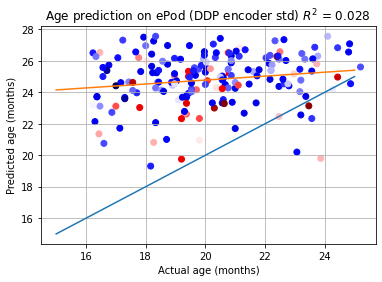


line coef. a = 0.1250758867567869 b = 22.275173391206874


In [105]:
model_info = model_name_w.value.split("_")

ages_real = np.array(results)[:,0]/30

# Correction values for DDP dataset
a = 0.3728
b = 15.78

correction_point = (a-1) * ages_real + b
correction_avg = (a-1) * np.average(ages_real) + b

ages_predicted = np.array(results)[:,1]/30

corr_coef = round(np.corrcoef(ages_real, ages_predicted)[0, 1], 3)
r2 = round(corr_coef**2,3)

display_helper.show_plot(ages_real, 
                         ages_predicted, 
                         f"Age prediction on ePod (DDP {model_info[1]} std) $R^2$ = {r2} ", 
                         "Actual age (months)",
                         "Predicted age (months)",
                         scatter=True,
                         scatter_color=color,
                         show=False)
                         #xlim = [5,46],
                         #ylim = [5,46])
plt.grid()

if dataset_name_w.value == "ddp":
    x, y = 5, 50
elif dataset_name_w.value  == "epodium":
    x, y = 15, 25

# Line where predicted=actual:
plt.plot([x, y], [x, y]) 

a, b = np.polyfit(ages_real, ages_predicted, 1)
plt.plot([x, y], [a*x+b, a*y+b]) 
plt.show()

print(f"\nline coef. a = {a} b = {b}")

#### Scatterplot results risk of dyslexia 

In [ ]:
model_info = model_name_w.value.split("_")

risk_real = np.array(results)[:,0]
risk_predicted = np.array(results)[:,1]

display_helper.show_plot(risk_real, 
                         risk_predicted, 
                         f"Parents score's from MMN ({model_info[0]} {model_info[1]})", 
                         "Actual score",
                         "Predicted score",
                         scatter=True,
                         show=False)
x, y = 0.3, 1
plt.plot([x, y], [x, y]) 

m, c = np.polyfit(risk_real, risk_predicted, 1)
plt.plot([x, y], [x*m+c, y*m+c]) 
plt.show()

### Additional tools: 
TODO: tweaking and cleaning

In [ ]:
# Save dataset in different dimension (sampling_rate, channels)
sample_rate=501
channels=dataset.channels_epod_ddp

# Loop over each epochs_fif file
experiment_paths = glob.glob(os.path.join(local_paths.ePod_epochs, '*.fif'))
for experiment_path in experiment_paths:
    path_epochs_ddp_dims = os.path.join(local_paths.ePod, "epochs_fif_500Hz_26ch", experiment + "_epo.fif")
    if os.path.exists(path_epochs_ddp_dims):
        continue
        
    filename_events = os.path.basename(experiment_path)
    experiment = filename_events.split(("_epo.fif"))[0]
    
    # Load and modify epochs
    print(f"Modifying experiment {experiment}")
    path_epochs = os.path.join(local_paths.ePod_epochs, experiment + "_epo.fif")
    epochs = mne.read_epochs(path_epochs, verbose=0)
    epochs.pick_channels(dataset.channels_epod_ddp)
    epochs.resample(sample_rate)
    
    # Save epochs with new dimensions
    epochs.save(path_epochs_ddp_dims)   

In [ ]:
# Tool to calculate mean score
array = np.array(labels["Dyslexia_score"])-0.68
square = np.square(array)
np.average(square)


In [ ]:
# Histogram dyslexia score
plt.hist(labels["Dyslexia_score"], bins=20)
plt.title('Parents\' normalized average scores on EMT, Klepel, and VC tests')
plt.xlabel('Score')
#plt.ylabel('')
plt.show


In [ ]:
# Save array of strings
path = os.path.join(local_paths.models, "clean_epod_experiments.txt")
array = np.array(testset)
np.savetxt(path, array, fmt='%s')

In [ ]:
len(testset)

In [ ]:
#n_passthroughs = 30

all_results = []

for n_passthrough in range(50):
    # For each experiment in the test-set
    results = []
    for i, experiment in enumerate(testset):
        # Set up relevant sequence (each experiment gets its own sequence)
        if dataset_name_w.value == "ddp":
            test_sequence = DDPSequence([experiment], labels, local_paths.DDP_epochs, batch_size=1,
                                        n_instances_per_experiment=n_passthrough+1, n_trials_averaged=30,
                                        standardise=True)
      
        # Get experiment
        x, y = test_sequence.__getitem__(0)

        # Make a prediction with the model.
        real_pred = [y[0], np.squeeze(model.predict(x, verbose=0)).mean()]
        results.append(real_pred)
    all_results.append(results)
    print(n_passthrough+1)
all_results = np.array(all_results)

In [ ]:
all_results2= all_results
errors = []
for i in range(50):
    error = np.diff(all_results[i])
    squared_error = np.square(error)
    mean_squared_error = np.average(squared_error)
    root_mean_squared_error = np.sqrt(mean_squared_error)
    
    absolute_error = np.absolute(error)
    mean_absolute_error = np.average(absolute_error)
    
    errors.append(mean_absolute_error)


display_helper.show_plot(x=range(50), 
                         y=np.array(errors)/30, 
                         xlabel="Number of sampled ERPs", ylabel="Average MAE (months)", 
                         title=f"Average error of predictions (DDP encoder std)",
                         xlim=[0,50])# , ylim=ylim)